# Reproduction of the paper of Weitz et al.

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Figure 1

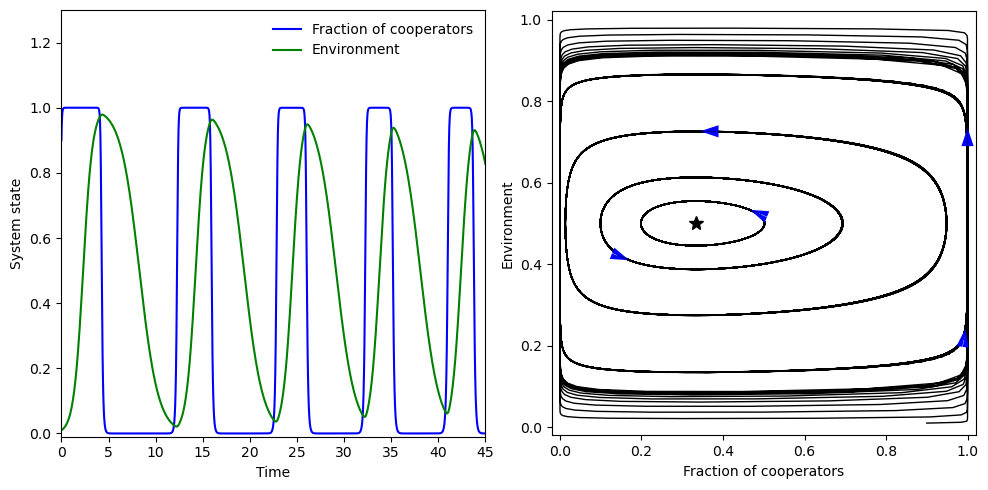

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def dynamics_symmetric(t, y, epsilon, theta, R, S, T, P):
    x, n = y
    
    # --- FIX: Clip variables to avoid numerical explosion ---
    x = np.clip(x, 0, 1)
    n = np.clip(n, 0, 1)
    # --------------------------------------------------------

    delta_PS = P - S
    delta_TR = T - R
    payoff_term = (1.0 - 2.0 * n) * (delta_PS + (delta_TR - delta_PS) * x)
    
    dxdt = (1.0 / epsilon) * x * (1.0 - x) * payoff_term
    dndt = n * (1.0 - n) * (-1.0 + (1.0 + theta) * x)
    
    return [dxdt, dndt]
def reproduce_figure_2():
    # Parameters from Weitz et al. 2016
    epsilon = 0.1
    theta = 2.0
    R, S, T, P = 3.0, 0.0, 5.0, 1.0

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # --- LEFT PANEL: Time Series ---
    # LSODA handles the "square wave" shape well
    sol = solve_ivp(dynamics_symmetric, (0, 45), [0.9, 0.01], 
                    t_eval=np.linspace(0, 45, 1000),
                    method='RK45',
                    args=(epsilon, theta, R, S, T, P),
                    max_step=0.1,    # Prevents jagged corners
                    rtol=1e-5,       # High precision relative
                    atol=1e-8)      # High precision absolute (Crucial!)
    
    ax = axes[0]
    ax.plot(sol.t, sol.y[0], 'b-', label='Fraction of cooperators')
    ax.plot(sol.t, sol.y[1], 'g-', label='Environment')
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')
    ax.set_xlim(0, 45)
    ax.set_ylim(-0.01, 1.3)
    ax.legend(loc='upper right', frameon=False)

    # --- RIGHT PANEL: Phase Plane ---
    ax = axes[1]
    initial_conditions = [(0.9, 0.01), (0.8, 0.15), (0.7, 0.3), (0.5, 0.4), (0.4, 0.45)]
    
    for ic in initial_conditions:
        # Loop closure is very sensitive to tolerance here
        sol_orbit = solve_ivp(dynamics_symmetric, (0, 100), ic, 
                              t_eval=np.linspace(0, 100, 1000), # Smooth plotting
                              method='RK45',
                              args=(epsilon, theta, R, S, T, P),
                              max_step=0.1,
                              rtol=1e-5, 
                              atol=1e-8) 
        
        ax.plot(sol_orbit.y[0], sol_orbit.y[1], 'k-', lw=1.0)
        
        # Add Arrows
        idx = len(sol_orbit.t) // 4
        x_curr, n_curr = sol_orbit.y[0][idx], sol_orbit.y[1][idx]
        dx, dn = dynamics_symmetric(0, [x_curr, n_curr], epsilon, theta, R, S, T, P)
        norm = np.hypot(dx, dn)
        ax.arrow(x_curr, n_curr, dx/norm*0.001, dn/norm*0.001, 
                 shape='full', lw=0, length_includes_head=True, 
                 head_width=0.03, color='blue', zorder=5)

    # Plot Fixed Point 
    fixed_x = 1.0 / (1.0 + theta)
    fixed_n = 0.5
    ax.plot(fixed_x, fixed_n, 'k*', markersize=10)

    ax.set_xlabel('Fraction of cooperators')
    ax.set_ylabel('Environment')
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

reproduce_figure_2()

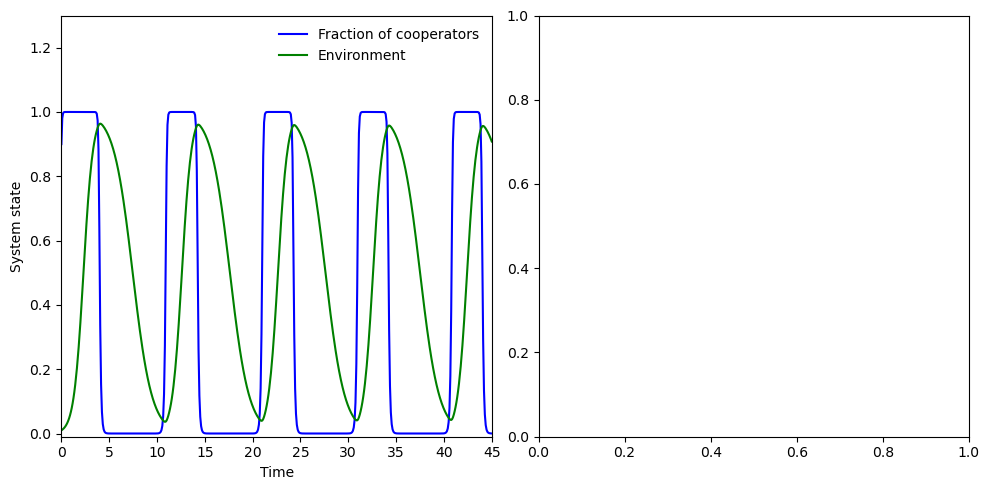

In [37]:
def reproduce_figure_2():
    # Parameters from Weitz et al. 2016
    epsilon = 0.1
    theta = 2.0
    R, S, T, P = 3.0, 0.0, 5.0, 1.0

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # --- LEFT PANEL: Time Series ---
    # Matches the smooth curves in Fig 2A
    sol = solve_ivp(dynamics_symmetric, (0, 45), [0.9, 0.01], 
                    method="BDF",
                    t_eval=np.linspace(0, 45, 500),
                    args=(epsilon, theta, R, S, T, P),
                    max_step=0.10, rtol=1e-7, atol=1e-11) #7, 11
    
    ax = axes[0]
    ax.plot(sol.t, sol.y[0], 'b-', label='Fraction of cooperators')
    ax.plot(sol.t, sol.y[1], 'g-', label='Environment')
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')
    ax.set_xlim(0, 45)
    ax.set_ylim(-0.01, 1.3)
    ax.legend(loc='upper right', frameon=False)
    
    plt.tight_layout()
    plt.show()

reproduce_figure_2()

Generating Figure 3...


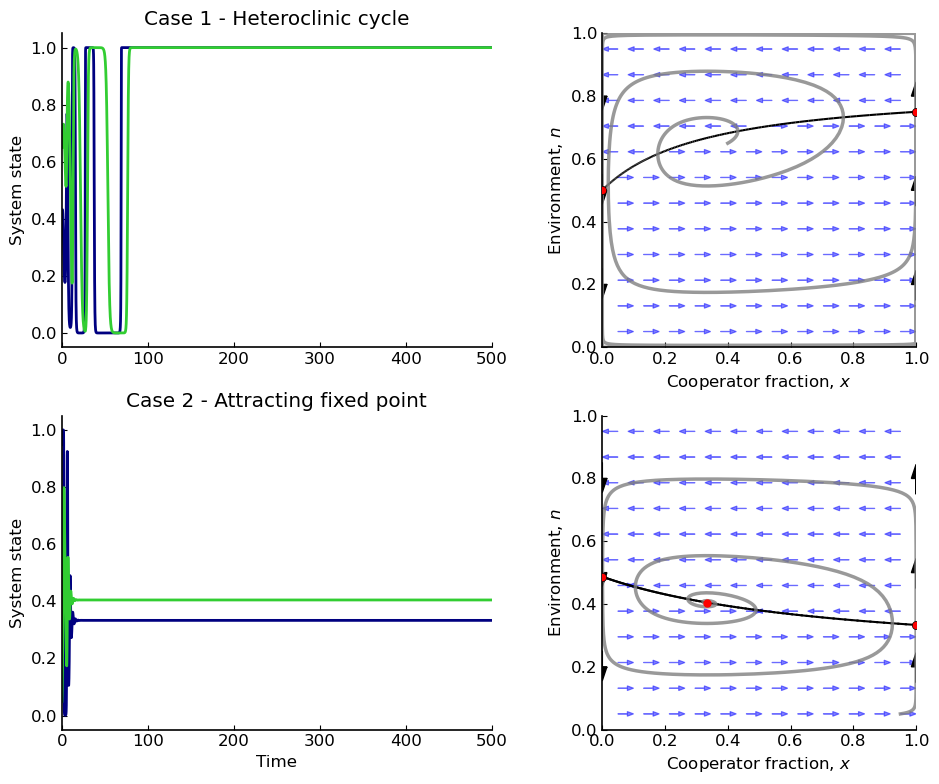

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ============================================================================
# 1. PLOTTING STYLE & CONFIGURATION
# ============================================================================
plt.rcParams.update({
    "font.size": 12,
    "font.family": "sans-serif",
    "lines.linewidth": 2,
    "axes.linewidth": 1.2,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "xtick.direction": "in",
    "ytick.direction": "in",
})

COLOR_COOP = '#000080'      # Navy Blue (x)
COLOR_ENV = '#32CD32'       # Lime Green (n)
COLOR_MANIFOLD_STABLE = 'black'
COLOR_MANIFOLD_UNSTABLE = 'black'  # Dashed
COLOR_FAST_ARROW = 'blue'
COLOR_SLOW_ARROW = 'black'
COLOR_BIFURCATION = 'red'

# ============================================================================
# 2. CORE DYNAMICS ENGINE
# ============================================================================

def get_payoff_matrix(n, A0, A1):
    """Linearly interpolate payoff matrix: A(n) = (1-n)A0 + nA1"""
    return (1 - n) * A0 + n * A1

def get_fast_parameters(n, A0, A1):
    """
    Returns coefficients (a, b) for the fast dynamics x' = x(1-x)(ax + b).
    
    Derivation:
    r1 - r2 = x(A11 - A21) + (1-x)(A12 - A22)
            = x[(A11 - A21) - (A12 - A22)] + (A12 - A22)
            = a*x + b
    """
    A = get_payoff_matrix(n, A0, A1)
    b = A[0, 1] - A[1, 1]
    a = (A[0, 0] - A[1, 0]) - b
    return a, b

def dynamics_general(t, y, epsilon, theta, A0, A1):
    """System dynamics for the general case (Eq. 20/21/23)."""
    x, n = y
    
    # 1. Fast variable (x) dynamics
    a, b = get_fast_parameters(n, A0, A1)
    fitness_diff = a * x + b
    dxdt = (1.0 / epsilon) * x * (1.0 - x) * fitness_diff
    
    # 2. Slow variable (n) dynamics
    # f(x) = -1 + (1+theta)x
    feedback = -1.0 + (1.0 + theta) * x
    dndt = n * (1.0 - n) * feedback
    
    return [dxdt, dndt]

def dynamics_symmetric(t, y, epsilon, theta, R, S, T, P):
    """System dynamics for the symmetric case (Eq. 17)."""
    x, n = y
    delta_PS = P - S
    delta_TR = T - R
    
    # Fitness difference term
    payoff_term = (1.0 - 2.0 * n) * (delta_PS + (delta_TR - delta_PS) * x)
    
    dxdt = (1.0 / epsilon) * x * (1.0 - x) * payoff_term
    dndt = n * (1.0 - n) * (-1.0 + (1.0 + theta) * x)
    return [dxdt, dndt]

# ============================================================================
# 3. ANALYTICAL HELPERS (Bifurcations & Stability)
# ============================================================================

def find_bifurcations(A0, A1):
    """
    Find saddle-node bifurcation points where the interior fixed point
    collides with the boundary (x=0 or x=1).
    
    x* = -b(n)/a(n)
    Collision with x=0 => b(n) = 0
    Collision with x=1 => a(n) + b(n) = 0
    """
    bifs = []
    
    # Coeffs are linear in n: P(n) = P0 + n(P1 - P0)
    a0, b0 = get_fast_parameters(0, A0, A1)
    a1, b1 = get_fast_parameters(1, A0, A1)
    
    # 1. Check b(n) = 0
    denom_b = b1 - b0
    if abs(denom_b) > 1e-9:
        n_0 = -b0 / denom_b
        if 0 <= n_0 <= 1:
            bifs.append((0, n_0)) # Bifurcation on x=0 line
            
    # 2. Check a(n) + b(n) = 0
    val0 = a0 + b0
    val1 = a1 + b1
    denom_val = val1 - val0
    if abs(denom_val) > 1e-9:
        n_1 = -val0 / denom_val
        if 0 <= n_1 <= 1:
            bifs.append((1, n_1)) # Bifurcation on x=1 line
            
    return bifs

def get_manifold_stability(n, A0, A1):
    """
    Determine if the interior fixed point is stable or unstable.
    Jacobian of fast subsystem J ~ a(n).
    If a < 0: Stable (Attractor)
    If a > 0: Unstable (Repeller)
    """
    a, b = get_fast_parameters(n, A0, A1)
    return "stable" if a < 0 else "unstable"

# ============================================================================
# 4. FIGURE REPRODUCTION FUNCTIONS
# ============================================================================

def reproduce_figure_2():
    """Reproduces Figure 2: Symmetric Case."""
    print("Generating Figure 2...")
    
    # [cite_start]Parameters [cite: 199]
    epsilon = 0.1
    theta = 2.0
    R, S, T, P = 3.0, 0.0, 5.0, 1.0
    
    # Setup Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # --- LEFT PANEL: Time Series ---
    # [cite_start]Initial condition (0.9, 0.01) [cite: 201]
    y0 = [0.9, 0.01]
    t_span = (0, 45)
    sol = solve_ivp(dynamics_symmetric, t_span, y0, args=(epsilon, theta, R, S, T, P),
                    rtol=1e-9, atol=1e-11, max_step=0.05)
    
    ax = axes[0]
    ax.plot(sol.t, sol.y[0], color=COLOR_COOP, label='Fraction of cooperators')
    ax.plot(sol.t, sol.y[1], color=COLOR_ENV, label='Environment')
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')
    ax.set_xlim(0, 45)
    ax.set_ylim(0, 1.2)
    ax.legend(loc='upper center', frameon=False, ncol=2, fontsize=10)
    
    # --- RIGHT PANEL: Phase Plane ---
    ax = axes[1]
    
    # [cite_start]Plot Multiple Orbits [cite: 201]
    initial_conditions = [
        (0.9, 0.01), (0.8, 0.15), (0.7, 0.3), (0.5, 0.4), (0.4, 0.45)
    ]
    
    for ic in initial_conditions:
        sol_orbit = solve_ivp(dynamics_symmetric, (0, 100), ic, 
                              args=(epsilon, theta, R, S, T, P),
                              rtol=1e-9, atol=1e-11, max_step=0.05)
        ax.plot(sol_orbit.y[0], sol_orbit.y[1], 'k-', lw=1.2)
        
        # Add directional arrows
        # Sample a point in the middle of the orbit for the arrow
        idx = len(sol_orbit.t) // 6
        x_arr, n_arr = sol_orbit.y[0][idx], sol_orbit.y[1][idx]
        dx, dn = dynamics_symmetric(0, [x_arr, n_arr], epsilon, theta, R, S, T, P)
        
        # Normalize arrow vector
        norm = np.hypot(dx, dn)
        ax.arrow(x_arr, n_arr, dx/norm*0.01, dn/norm*0.01, 
                 shape='full', lw=0, length_includes_head=False, 
                 head_width=0.03, color='blue', zorder=5)

    # [cite_start]Plot Interior Fixed Point (Asterisk) [cite: 203]
    # x* = 1/(1+theta) = 1/3, n* = 0.5
    ax.plot(1.0/(1.0+theta), 0.5, 'k*', markersize=10, zorder=10)
    
    ax.set_xlabel('Fraction of cooperators')
    ax.set_ylabel('Environment')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

def plot_fast_slow_phase_plane(ax, A0, A1, traj_sol, title_text):
    """Helper to draw the detailed phase planes for Fig 3."""
    
    # 1. Critical Manifolds
    n_space = np.linspace(0, 1, 600)
    x_c_list = []
    n_c_list = []
    stability_list = []
    
    for n in n_space:
        a, b = get_fast_parameters(n, A0, A1)
        if abs(a) > 1e-6:
            x_val = -b / a
            if 0 <= x_val <= 1:
                x_c_list.append(x_val)
                n_c_list.append(n)
                stability_list.append(get_manifold_stability(n, A0, A1))
            else:
                x_c_list.append(np.nan)
                n_c_list.append(np.nan)
                stability_list.append(None)
        else:
            x_c_list.append(np.nan)
            n_c_list.append(np.nan)
            stability_list.append(None)
            
    # Plot segments based on stability
    for i in range(len(x_c_list) - 1):
        if np.isnan(x_c_list[i]) or np.isnan(x_c_list[i+1]):
            continue
        
        style = '-' if stability_list[i] == 'stable' else '--'
        ax.plot(x_c_list[i:i+2], n_c_list[i:i+2], color='black', ls=style, lw=1.5)

    # [cite_start]2. Fast Dynamics Arrows (Double Arrows - Blue) [cite: 253]
    # Grid of arrows
    y_grid = np.linspace(0.05, 0.95, 12)
    x_grid = np.linspace(0.05, 0.95, 12)
    
    for n in y_grid:
        a, b = get_fast_parameters(n, A0, A1)
        for x in x_grid:
            # Direction of x'
            dx = a*x + b # Sign determines direction
            if abs(dx) > 1e-4:
                direction = np.sign(dx)
                # Plot "double arrow" simply as a distinct blue arrow
                ax.arrow(x, n, direction*0.03, 0, 
                         head_width=0.015, head_length=0.02, 
                         fc=COLOR_FAST_ARROW, ec=COLOR_FAST_ARROW, alpha=0.5, lw=0.8)

    # [cite_start]3. Slow Dynamics Arrows (Single Arrows - Black on boundaries) [cite: 254]
    # x=0 boundary: n' < 0 (down)
    # x=1 boundary: n' > 0 (up)
    for y_arrow in [0.2, 0.5, 0.8]:
        ax.arrow(0, y_arrow+0.05, 0, -0.05, head_width=0.03, fc='k', ec='k')
        ax.arrow(1, y_arrow-0.05, 0, 0.05, head_width=0.03, fc='k', ec='k')

    # [cite_start]4. Bifurcation Points (Red Circles) [cite: 253]
    bifs = find_bifurcations(A0, A1)
    for bx, bn in bifs:
        ax.plot(bx, bn, 'ro', markersize=6, mec='k', mew=0.5, zorder=10)

    # [cite_start]5. Realized Trajectory (Gray) [cite: 254]
    if traj_sol is not None:
        ax.plot(traj_sol.y[0], traj_sol.y[1], color='gray', lw=2.5, alpha=0.8)

    # Styling
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.set_xlabel('Cooperator fraction, $x$')
    ax.set_ylabel('Environment, $n$')
    # Add title inside plot for compactness if needed, or title
    

def reproduce_figure_3():
    """Reproduces Figure 3: Fast-Slow Dynamics."""
    print("Generating Figure 3...")
    
    epsilon = 0.1
    theta = 2.0
    
    # --- Case 1: Heteroclinic Cycle (Top) ---
    # Payoffs
    A0_het = np.array([[3.5, 1.0], [2.0, 0.75]])
    A1_het = np.array([[4.0, 1.0], [4.5, 1.25]])
    
    # Initial Condition visually estimated to match trace starting position
    y0_het = [0.4, 0.65] 
    
    sol_het = solve_ivp(dynamics_general, (0, 500), y0_het, 
                        args=(epsilon, theta, A0_het, A1_het),
                        rtol=1e-9, atol=1e-11, max_step=0.1)

    # --- Case 2: Attracting Fixed Point (Bottom) ---
    # Payoffs
    A0_fix = np.array([[3.5, 1.0], [2.0, 0.05]])
    A1_fix = np.array([[4.0, 1.0], [7.0, 2.0]])
    
    # Initial Condition visually estimated
    y0_fix = [0.95, 0.05]
    
    sol_fix = solve_ivp(dynamics_general, (0, 500), y0_fix, 
                        args=(epsilon, theta, A0_fix, A1_fix),
                        rtol=1e-9, atol=1e-11, max_step=0.1)

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    # Top Row
    axes[0,0].plot(sol_het.t, sol_het.y[0], color=COLOR_COOP)
    axes[0,0].plot(sol_het.t, sol_het.y[1], color=COLOR_ENV)
    axes[0,0].set_xlim(0, 500)
    axes[0,0].set_ylabel('System state')
    axes[0,0].set_title('Case 1 - Heteroclinic cycle')
    
    plot_fast_slow_phase_plane(axes[0,1], A0_het, A1_het, sol_het, "")
    
    # Bottom Row
    axes[1,0].plot(sol_fix.t, sol_fix.y[0], color=COLOR_COOP)
    axes[1,0].plot(sol_fix.t, sol_fix.y[1], color=COLOR_ENV)
    axes[1,0].set_xlim(0, 500)
    axes[1,0].set_ylabel('System state')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_title('Case 2 - Attracting fixed point')
    
    plot_fast_slow_phase_plane(axes[1,1], A0_fix, A1_fix, sol_fix, "")
    
    # Add Fixed Point marker for Bottom Right
    # It lies on interior manifold. x* = 1/(1+theta) = 1/3
    x_star = 1.0/3.0
    # Solve for n*: a(n)*x + b(n) = 0
    # Linear interpolation logic used in `find_bifurcations` can be used here inversely
    # But strictly, the simulation ends there, so we can plot the last point.
    axes[1,1].plot(sol_fix.y[0][-1], sol_fix.y[1][-1], 'ro', markersize=5, zorder=20)
    
    plt.tight_layout()
    plt.show()

def reproduce_figure_4():
    """Reproduces Figure 4: Invariance to Epsilon."""
    print("Generating Figure 4...")
    
    theta = 2.0
    epsilons = [0.1, 0.3, 1.0, 3.2, 10.0]
    
    # Payoffs same as Fig 3
    A0_het = np.array([[3.5, 1.0], [2.0, 0.75]])
    A1_het = np.array([[4.0, 1.0], [4.5, 1.25]])
    
    A0_fix = np.array([[3.5, 1.0], [2.0, 0.05]])
    A1_fix = np.array([[4.0, 1.0], [7.0, 2.0]])
    
    # Use consistent ICs from Fig 3
    y0_het = [0.4, 0.65]
    y0_fix = [0.95, 0.05]
    
    fig, axes = plt.subplots(len(epsilons), 2, figsize=(8, 10), sharex=True, sharey=True)
    
    for i, eps in enumerate(epsilons):
        # Left Col: Heteroclinic
        sol_L = solve_ivp(dynamics_general, (0, 200), y0_het, 
                          args=(eps, theta, A0_het, A1_het),
                          rtol=1e-8, atol=1e-10)
        
        axL = axes[i, 0]
        axL.plot(sol_L.t, sol_L.y[0], color=COLOR_COOP, lw=1.5)
        axL.plot(sol_L.t, sol_L.y[1], color=COLOR_ENV, lw=1.5, alpha=0.8)
        
        # Inset text for epsilon
        axL.text(0.05, 0.15, rf'$\epsilon = {eps}$', transform=axL.transAxes, fontsize=10)
        
        # Right Col: Fixed Point
        sol_R = solve_ivp(dynamics_general, (0, 200), y0_fix, 
                          args=(eps, theta, A0_fix, A1_fix),
                          rtol=1e-8, atol=1e-10)
        
        axR = axes[i, 1]
        axR.plot(sol_R.t, sol_R.y[0], color=COLOR_COOP, lw=1.5)
        axR.plot(sol_R.t, sol_R.y[1], color=COLOR_ENV, lw=1.5, alpha=0.8)
        axR.text(0.05, 0.15, rf'$\epsilon = {eps}$', transform=axR.transAxes, fontsize=10)

    # Axes Labels
    axes[0, 0].set_ylim(0, 1.1)
    axes[2, 0].set_ylabel("System state")
    axes[-1, 0].set_xlabel("Time")
    axes[-1, 1].set_xlabel("Time")
    
    # Legend on top left
    axes[0, 0].legend(['Fraction of cooperators', 'Environment'], 
                      loc='upper left', frameon=False, fontsize=8, bbox_to_anchor=(0, 1.25))

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()

if __name__ == "__main__":
    reproduce_figure_3()